In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.utils.configuration import get_config
from bold_dementia.utils.saving import save_run
from bold_dementia.stats.univariate import make_fc_data, run_test, export_results, merge_configs
from bold_dementia.connectivity import reshape_pvalues, plot_matrix, Atlas, pivot_resdf, edges_to_matrix

ALPHA = config["alpha"]

In [2]:
ATLAS = "GINNA"
atlas = Atlas.from_name(ATLAS)

In [3]:
expname = f"atlas-{ATLAS}_test_ols-cenanom"
respath = Path(config["output_dir"]) / "statresults" / expname

In [4]:
null = pd.read_csv(respath / "null_distribution_5000.csv", index_col=0)
resdf = pd.read_csv(respath / "resdf.csv", index_col=0)

In [5]:
permutation_scores = null.select_dtypes(float).values # Last col is edge name
score = resdf["beta_AD"].values
score = np.stack([score for _ in range(permutation_scores.shape[1])], axis=1) # Make scores broadcastable on permutation_scores

In [6]:
np.abs(permutation_scores) >= np.abs(score)

array([[ True, False,  True, ...,  True, False,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True, False,  True, ...,  True,  True,  True],
       [False, False, False, ..., False,  True, False]])

In [7]:
N = permutation_scores.shape[1]
pvalues = (1 + np.sum(np.abs(permutation_scores) >= np.abs(score), axis=1)) / (N + 1)

In [8]:
from statsmodels.stats.multitest import fdrcorrection
print(f"Correcting FDR with {len(pvalues)} comparisons")
_, pvalues_corr = fdrcorrection(pvalues, method="poscorr")

Correcting FDR with 528 comparisons


In [9]:
np.sum(pvalues_corr < config["alpha"])

0

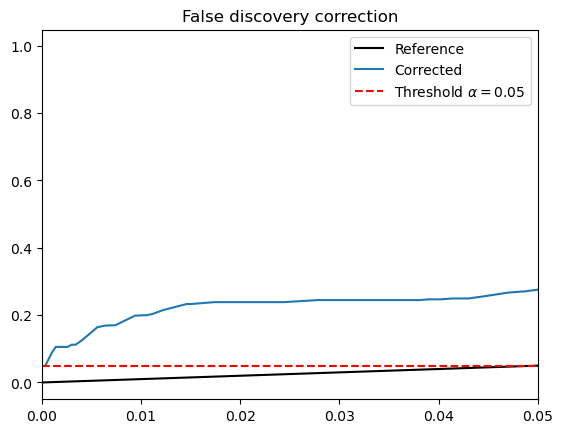

In [11]:
from bold_dementia.stats.fdr import plot_fdr

plot_fdr(pvalues, pvalues_corr)
plt.show()

In [19]:
# TODO Show matrix or export
from bold_dementia.connectivity import edges_to_matrix
resdf["pvalues_perm_fdr"] = pvalues_corr
resdf["thresholded_beta"] = np.where(pvalues_corr < ALPHA, resdf.beta_AD, 0)
pv = edges_to_matrix(resdf)

In [20]:
from bold_dementia.visualisation.chord_plot import make_links, create_chord
matrix_df = pv.thresholded_beta
links = make_links(matrix_df, zoom=5)

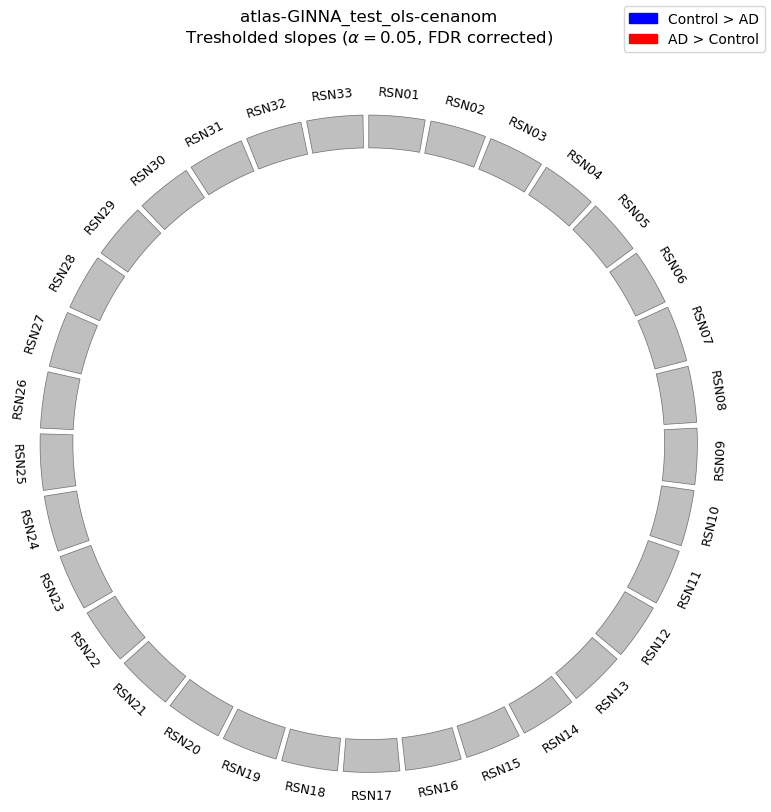

In [21]:
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label='Control > AD')
red_patch = mpatches.Patch(color='red', label='AD > Control')

networks = matrix_df.columns.to_list()
fig = create_chord(networks, links, size=9)
fig.legend(handles=[blue_patch, red_patch])
fig.suptitle(
    f"{expname}\nTresholded slopes ($\\alpha = ${ALPHA}, FDR corrected)",
    y=1.01
)
plt.show()

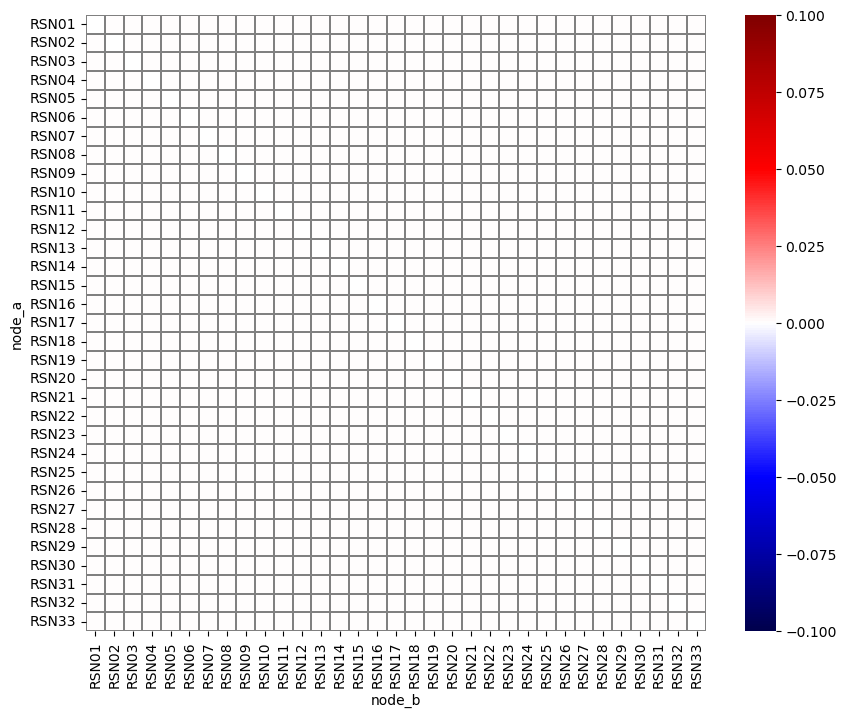

In [22]:
span = np.max(np.abs(matrix_df.values))
plt.subplots(figsize=(10, 8))
sns.heatmap(matrix_df, vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray")
plt.show()

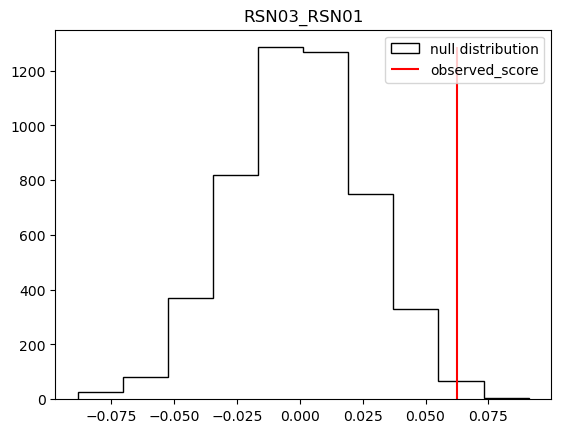

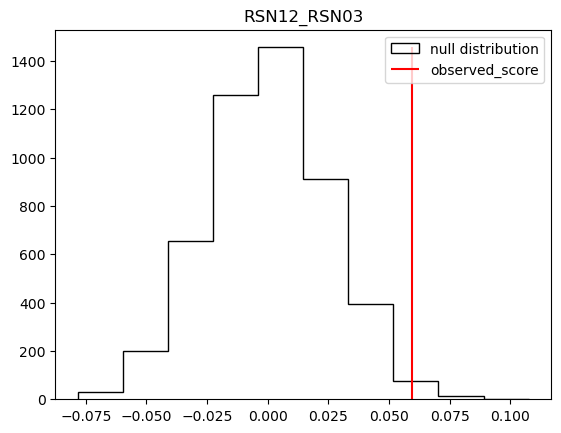

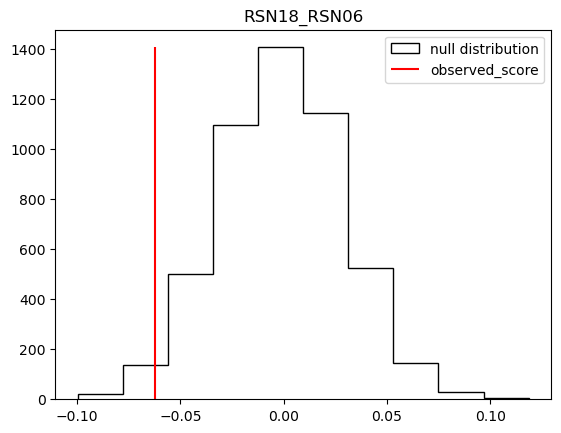

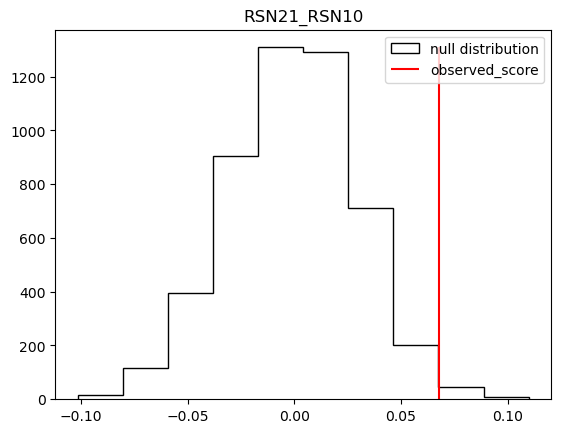

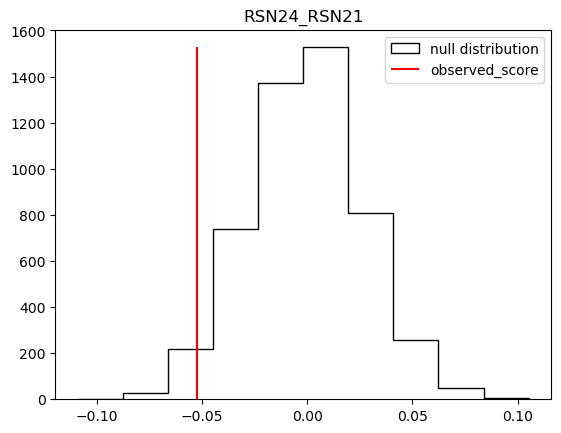

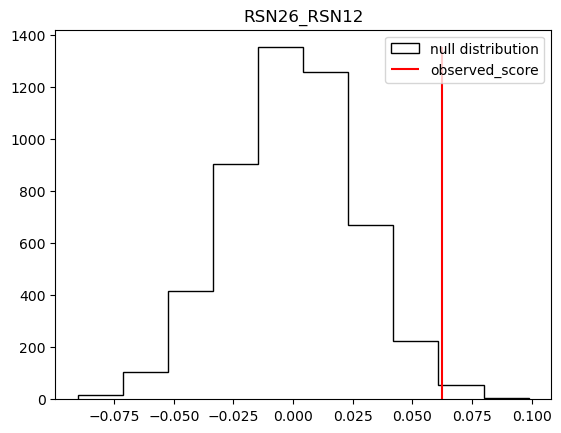

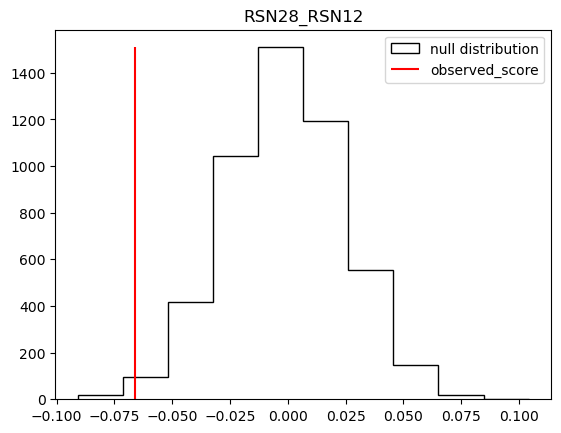

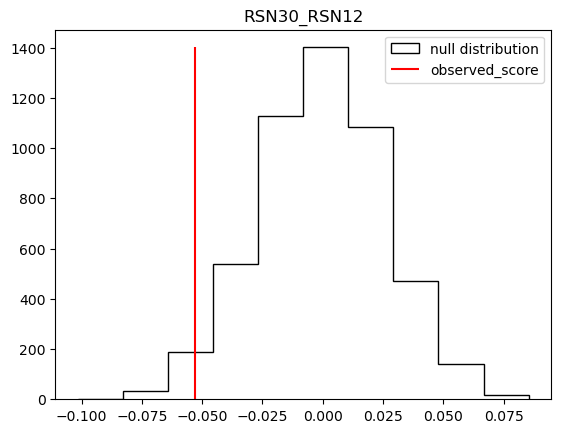

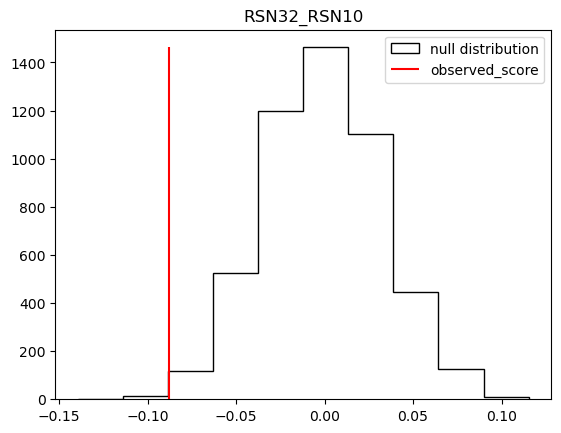

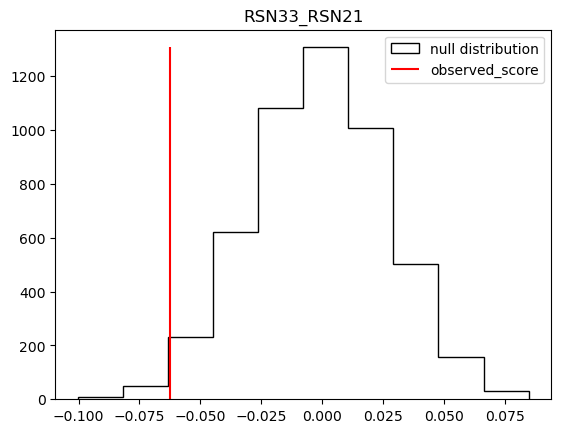

In [25]:

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

sig_idx = np.where(pvalues <= ALPHA)[0]

for idx in sig_idx[::10]:
    reference = permutation_scores[idx, :]
    observed_score = resdf.loc[idx, "beta_AD"]
    values, _, _ = plt.hist(reference, histtype="step", color="black", label="null distribution")
    plt.vlines(observed_score, 0, np.max(values), color="red", label="observed_score")
    plt.title(resdf.loc[idx, "edges"])
    plt.legend()
    plt.show()